This is a supplementary file for the tutorial this week and can be safely ignored
solutions will also be posted for this at the end of the week if you are interested
if you find any errors please notify me at omarghattas1991@gmail.com

Aim: We are going to explore three fundamental algorithms that are the basis for deep learning:
1. the Perceptron training rule
2. Gradient Descent
3. Stochastic Gradient Descent

At the end of this lab you should be comfortable with perceptron training and the basics of 
gradient descent -> be able to start thinking about neural networks and building them from scratch 


In [33]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(43)
%matplotlib inline

## Helper Functions

In [34]:
def plot_scatter(X, y, w):
    pos_points = X[np.where(y==1)[0]]
    neg_points = X[np.where(y==-1)[0]]
    plt.scatter(pos_points[:, 1], pos_points[:, 2], color='blue')
    plt.scatter(neg_points[:, 1], neg_points[:, 2], color='red')
    xx = np.linspace(-6,6)
    yy = -w[0]/w[2] - w[1]/w[2] * xx
    plt.plot(xx, yy, color='orange')
    
    ratio = (w[2]/w[1] + w[1]/w[2])
    xpt = (-1*w[0] / w[2]) * 1/ratio
    ypt = (-1*w[0] / w[1]) * 1/ratio
    
    plt.axes().arrow(xpt, ypt, w[1], w[2], head_width=0.2, color='orange')
    plt.axis('equal')
    plt.show()
    
#plot_scatter(X, y, w=np.array([0,-1,3]))

In [35]:
def generate_data(n=20):
    dist_01 = np.random.multivariate_normal(np.array([3,3]), np.array([[1,0.9],[0.5,1]]), n)
    dist_02 = np.random.multivariate_normal(np.array([-1,-1]),np.array([[1,0],[0.3,1]]), n)
    X = np.concatenate((np.ones(2*n).reshape(-1,1), np.concatenate((dist_01, dist_02))), axis=1)
    y = np.concatenate((np.ones(n), -1*np.ones(n)))
    shuffle_idx = np.random.choice(2*n, size=2*n, replace=False)
    X = X[shuffle_idx]
    y = y[shuffle_idx]
    return X, y

## Perceptron Training Rule

In [37]:
def train_perceptron(X, y, eta=1):
    
    w = np.random.random(3)       # randomly init weight vector
    nmb_data = X.shape[0]
    
    nmb_its = 0
    counter = 0
    
    while True:
        for i in range(nmb_data):
            nmb_its += 1
            
            if (y[i] * (w.T @ X[i]) < 0):
                # mistake - update weights, reset counter
                w = w + eta * y[i] * X[i]
                plot_scatter(X, y, w)
                counter = 0
                print(f"Iteration {nmb_its}: w = {w}")
            
            counter += 1

            if(counter>nmb_data):
                # we have cycled through the entire dataset without making an update
                plot_scatter(X, y, w)
                print(f"Converged after {nmb_its} iterations")
                return

/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: covariance is not positive-semidefinite.
  
/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: covariance is not positive-semidefinite.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


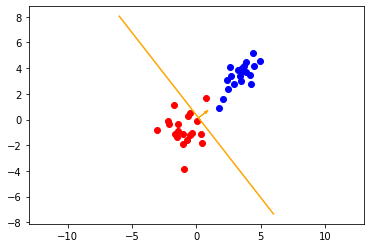

Iteration 4: w = [-0.13943616  0.51579181  0.40228309]


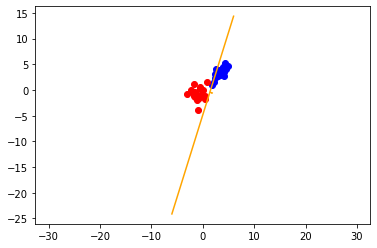

Iteration 19: w = [-0.43943616  0.28865846 -0.09006144]


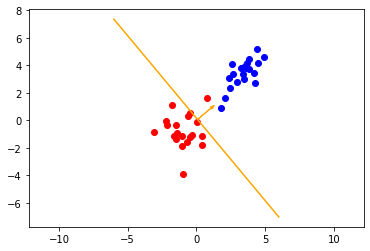

Iteration 29: w = [-0.13943616  0.99891584  0.8330248 ]


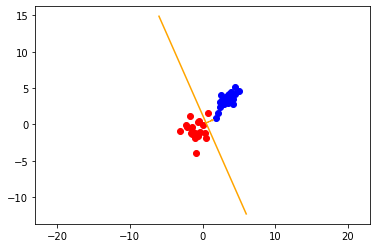

Iteration 59: w = [-0.43943616  0.7717825   0.34068027]


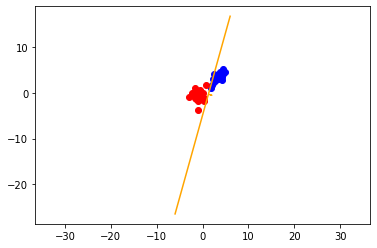

Iteration 99: w = [-0.73943616  0.54464915 -0.15166426]


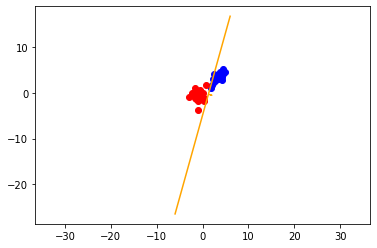

Converged after 139 iterations


In [40]:
X, y = generate_data()
train_perceptron(X, y, eta=0.3)

## Gradient Descent

The original perceptron uses the sign function as its sigmoid (a sigmoid function is any function that has an 'S' shape):

$$
sgn(x) = 
\begin{cases}
1 & \text{if } x\ge0,\\
-1 & \text{if } x<0.\\
\end{cases}
$$

This function can be a bit problematic since it is discontinuous, and in this section we need to consider derivatives of the sigmoid. We introduce another sigmoid function, called the logistic sigmoid:

$$
\sigma(x) = \frac{1}{1+e^{-ax}}
$$

where $a$ is a constant that controls the steepness of the function. Now, note that

$$
\frac{d \sigma(x)}{d x} = \sigma(x) (1-\sigma(x))
$$


We can now implement the sigmoid and its derivative and observe its shape for different values of the steepness parameter:

In [50]:
def sigmoid(x,a=1):
    return 1/(1+np.exp(-a*x))

def grad_sigmoid(x, a=1):
    return sigmoid(x,a) * (1-sigmoid(x, a))

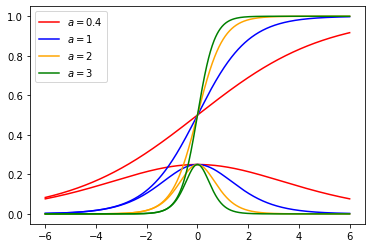

In [51]:
# plot sig functions 
xx = np.linspace(-6,6,1000)
a_vals = [0.4,1,2,3]
cols = ['red', 'blue', 'orange', 'green']
y_sig = [sigmoid(xx, a_val) for a_val in a_vals]
y_grad_sig = [grad_sigmoid(xx, a_val) for a_val in a_vals]

for i in range(len(a_vals)):
    label = str(a_vals[i])
    plt.plot(xx, y_sig[i], label=rf'$a={label}$', color=cols[i])
    plt.plot(xx, y_grad_sig[i], color=cols[i])
plt.legend()
plt.show()

Now, under the perceptron training algorithm, we update the weight vector everytime the algorithm makes a mistake, i.e. whenever $w^T x y < 0$. While this works well when the data are linearly seperable, the loop goes on forever if there is any cross over of the points - in other words, the perceptron training rule is unable to model non-linearly seperable data. In order to extend the perceptron so that it is able to handle this problem, we take a different view on training, which is the standard approach in Machine Learning.

Recall that the prediction (output) of the perceptron is $\hat{y} = \sigma(w^T x)$, and so the mean sum of squared errors (MSE) is simply:

$$
L(w) = \frac{1}{2}\sum_{i=1}^N (y_i - \hat{y}_i)^2 = \frac{1}{2} \sum_{i=1}^N (y_i - \sigma(w^Tx_i))^2.
$$

Note that as we change $w$, we get a different value for the MSE. Ideally, we would like to make the MSE as small as possible, and so we seek a way of finding the w that minimises $L$. 

In the first tutorial, we did this analytically for the case of Linear Regression by taking derivatives and solving for $w$. Here, we will take an algorithmic approach, using an algorithm called Gradient Descent. Gradient Descent is the workhorse of modern machine learning/deep learning methods, and the basic idea is extremly simple:

1. Initialise $w$
2. Take a small step in the direction of the minimum of $L$
3. Repeat step 2 until $L(w)$ is minimised.

Now, the direction of the minimum is the direction of greatest decrease of L, and is simply given by the negative of the gradient of $L$:

$$
\nabla_w L(w) \equiv \left ( \frac{\partial L(w)}{\partial w_0}, \frac{\partial L(w)}{\partial w_1}, \dots, \frac{\partial L(w)}{\partial w_p} \right )
$$

So, gradient descent simply becomes:
1. Initialise $w$
2. Update $w = w - \eta \nabla_w L(w)$
3. Repeat step 2 until $L(w)$ is minimised.

where $\eta$  is the learning rate, and controls how large the steps we are taking are going to be. For a more detailed look at gradient descent, check out this video: https://www.youtube.com/watch?v=WnqQrPNYz5Q

Now, in order to carry out gradient descent, we just need to figure out what $\nabla_w L(w)$ actually is:

\begin{align*}
\nabla L(w) &= \frac{1}{2} \sum_{i=1}^N  \nabla (y_i - \sigma(w^T x_i))^2 \\
&= \sum_{i=1}^N  (y_i - \sigma(w^T x_i)) ( -x_i  ) \sigma(w^T x_i) (1-\sigma(w^T x_i)) \\
\end{align*}

So, Gradient Descent here is just
1. Initialise $w$
2. Update $w = w - \eta  \left ( \sum_{i=1}^N  (y_i - \sigma(w^T x_i)) ( -x_i  ) \sigma(w^T x_i) (1-\sigma(w^T x_i)) \right )  $
3. Repeat step 2 until $L(w)$ is minimised.

Let's code this up:


In [41]:
def loss_i(w, x_i, y_i):
    '''squared loss for i-th data point'''
    return (y_i - sigmoid(w@x_i))**2
    
def grad_loss_i(w, x_i, y_i):
    '''grad loss for i-th data point'''
    return (y_i - sigmoid(w@x_i)) * (-x_i) * grad_sigmoid(w@x_i)

def gradient_descent(X, y, eta, T):
    # T is the number of updates -> how many times to loop through the ENTIRE dataset
    nmb_data = X.shape[0]
    w = np.array([-2,-1,-3]) # init w
    for t in range(T):
        loss = 0
        grad_loss = 0
        for i in range(nmb_data):
            loss += loss_i(w, X[i], y[i])
            grad_loss += grad_loss_i(w, X[i], y[i])
        loss *= 0.5
        print(f"loss = {loss}")
        w = w - eta * grad_loss
        plot_scatter(X,y,w)

Note: try playing around with the data generating function to get more overlapping data, compare this to perceptron training. Look at what is happening to the loss as we progress - in most ML problems, it is hard to visualise the learning and so we rely on monitoring the loss function to see how well we're doing

loss = 104.53342057073924


/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: covariance is not positive-semidefinite.
  
/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: covariance is not positive-semidefinite.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


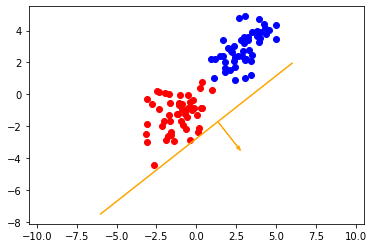

loss = 52.69276361294484


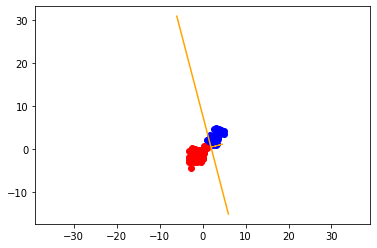

loss = 26.635931296953572


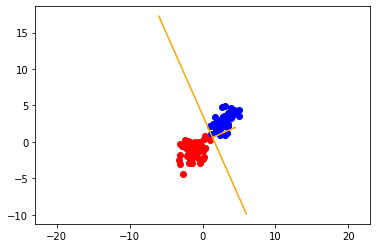

loss = 25.515125899054357


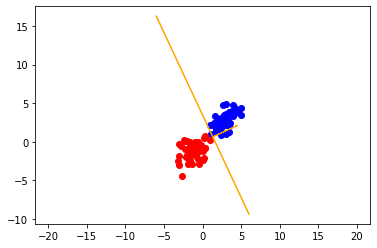

loss = 25.49011441939788


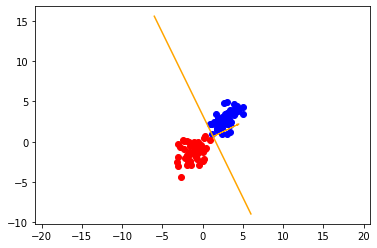

loss = 25.47376453048273


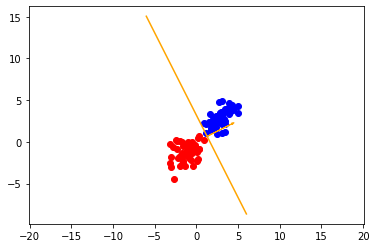

loss = 25.460874435264063


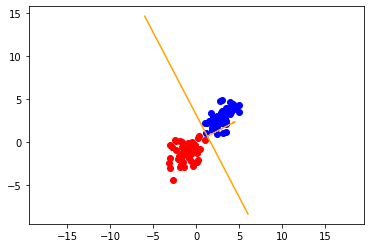

loss = 25.449790160237555


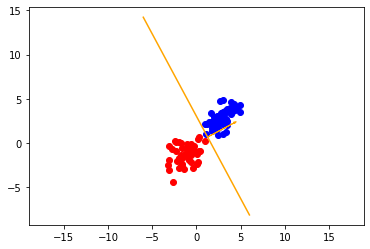

loss = 25.439866778863117


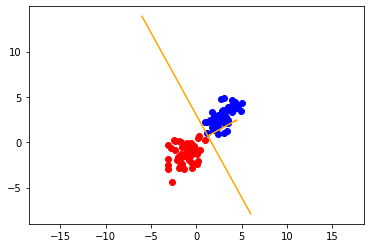

loss = 25.430804708856574


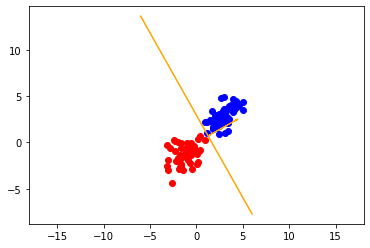

In [54]:
X, y = generate_data(50)
gradient_descent(X, y, 0.3, 10)

## Stochastic Gradient Descent

Finally, we consider an extension of gradient descent, called stochastic gradient descent. In GD, we need to compute the gradient of the loss, which means summing over the entire data set before we do any updates. This can be painfully slow when we have big data sets. Alternatively, we can try to estimate the gradient of the loss by looking at the sum of the gradient loss terms for a subset of the data, often called a batch size. In the following implementation, we consider a batch size of 1. In other words, we update the weight vector each time we see an observation, rather than wait for the entire dataset. Note that this is not ideal behaviour, and will give us large variance in our updates. Try to improve this by considering different batch sizes.

In [55]:
def stochastic_gradient_descent(X, y, eta, T=5):
    nmb_data = X.shape[0]
    w = np.array([-2,-1,-3])
    for t in range(T):
        loss = 0
        grad_loss = 0
        for i in range(nmb_data):
            loss += loss_i(w, X[i], y[i])
            grad_loss += grad_loss_i(w, X[i], y[i])
            plot_scatter(X,y,w)
        loss *= 0.5
        print(f"loss = {loss}")
        w = w - eta * grad_loss
        plot_scatter(X,y,w)

Extensions:
1. improve the SGD implementation by considering batches of size greater than 1
2. Apply GD and SGD to linear regression from the first tutorial.
3. Investigate other sigmoid functions and implement them: https://en.wikipedia.org/wiki/Sigmoid_function